Exploring data to check data quality and sanity checks


##### Phase 1 – Exploratory Data Analysis (EDA)

<small>**Objective**  
Evaluate data quality, feature validity, and leakage risk for building a 1-year Probability of Default (PD) model.

**Key Outcomes Expected**
- Identify usable upstream borrower features
- Flag data quality issues requiring cleaning
- Exclude leaky or downstream variables
- Define target variable and class balance

**Explicit Assumptions**
- Loan tenure is fixed at 1 year
- Default definition is binary (loan_status)</small>


##### Feature Role Legend<small>
- ✅ Upstream borrower feature (usable for modeling)
- ⚠️ Usable but requires cleaning or validation
- ❌ Excluded due to leakage or redundancy
- 🎯 Target variable</small>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("../data/raw/raw.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


##### Person Age ⚠️
<small>**Real Word Meaning:**<br> Age of borrower at loan application<br><br>
**Expected/Impossible values:**
1) Impossible: age<18 or age>100
2) Suspicious: very young(<21) or too old(>80)

**Expected distribution shape**
1) Right-skewed
2) Peak in working-age range

**Risk intuition**
1) Very young indicates higher default risk
2) Middle age indicates lower risk

**Notes / flags**
1) Check for unrealistic ages</small>



count    32581.000000
mean        27.734600
std          6.348078
min         20.000000
25%         23.000000
50%         26.000000
75%         30.000000
max        144.000000
Name: person_age, dtype: float64

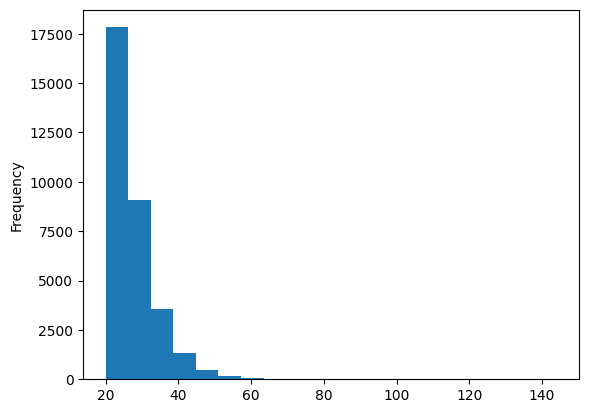

In [2]:
df['person_age'].plot.hist(bins=20)
df['person_age'].describe()



<small>**Observation**

1) The majority of borrowers fall between ages 20 and 40, which aligns with a typical working age population
2) The distribution is right-skewed
3) A small number of records report ages greater than 100, with a maximum of 144, which is not possible
4) These extreme values likely represent data quality issues and should be flagged for handling during data cleansing</small>



##### Person Income ✅
<small>**Real Word Meaning:**<br> Yearly income of borrower at loan application<br><br>
**Expected/Impossible values:**
1) Impossible: income<0 

**Risk intuition**<br>
1) Income less compared to loan amount indicates more risk
2) Income distribution for lower incomes matter more for risk than at higher incomes

**Notes / flags**
1) Check for impossible incomes
2) Use income/loan amount ratio might be a better indicator for risk</small>

count    3.258100e+04
mean     6.607485e+04
std      6.198312e+04
min      4.000000e+03
25%      3.850000e+04
50%      5.500000e+04
75%      7.920000e+04
max      6.000000e+06
Name: person_income, dtype: float64

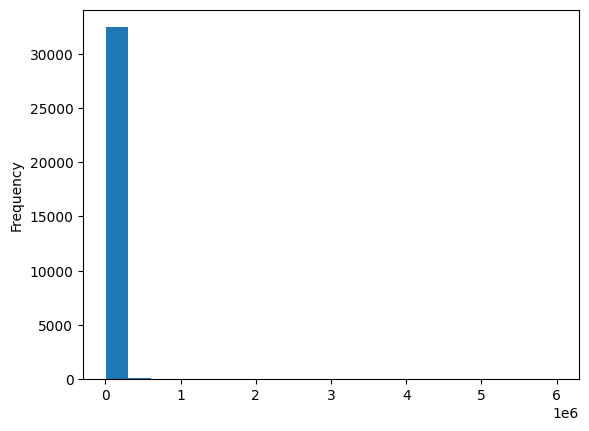

In [3]:
df['person_income'].plot.hist(bins=20)
df['person_income'].describe()

<small>**Observation**

1) Income is heavily right scewered 
2) Income alone does not indicate risk potential, reasonably compared with loan amount
3) most users fall under majorily in the low income bracket</small>



##### Person Home Ownership ✅
<small>**Real Word Meaning:**<br> Type of housing users are currently in<br><br>
**Expected/Impossible values:**
1) Impossible: null values

**Risk intuition**<br>
1) RENT may indicate more financial instability than OWN/MORGAGE

**Notes / flags**
1) Check for null values
2) Less likely to be a cause for risk, indicates financial stability</small>

person_home_ownership
RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: count, dtype: int64

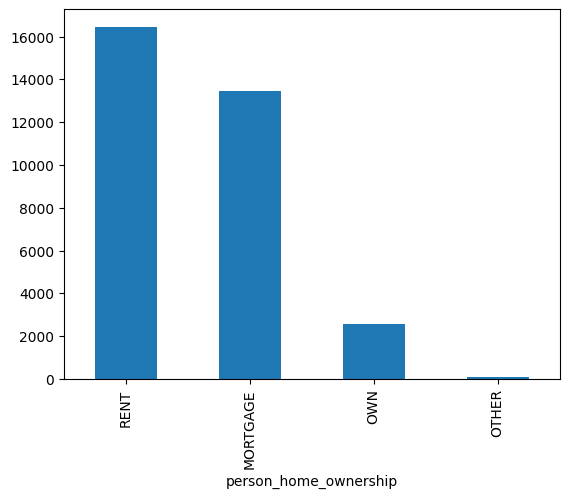

In [4]:
df['person_home_ownership'].value_counts().plot.bar()
df['person_home_ownership'].value_counts()


<small>**Observation**

1) Rent and Morgange dominate the ownership distribution 
2) Other seems insignificant to the other ownership counts</small>



##### Employment Time Period ⚠️
<small>**Real Word Meaning:**<br> How long the user has been employed<br><br>
**Expected/Impossible values:**
1) Impossible: period>100 and period> person age-18

**Risk intuition**<br>
1) Individuals with higher employment period indicate more financial stability and less risk

**Notes / flags**
1) Check for unreasonable employment period
2) Compare employment period with age</small>

count    31686.000000
mean         4.789686
std          4.142630
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: person_emp_length, dtype: float64


7836

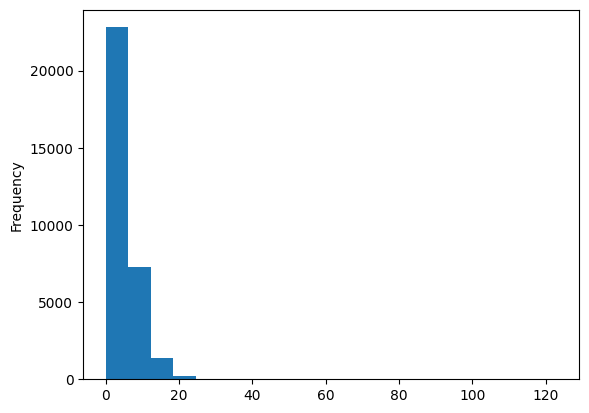

In [5]:
df['person_emp_length'].plot.hist(bins=20)
print(df['person_emp_length'].describe())
df[df['person_emp_length'] > df['person_age']-18].shape[0]

<small>**Observation**

1) Total numeric count of values is less than total count of records indicating missing values
2) employment period seems to be packed near the 4 years mark 
3) Impossible values seem to be observed here
4) Around 25% of the data violates age conditions for employment. 
5) Further analysis on whether some values are in months or value capping/removing would be required before processing</small>



##### Loan Intent ✅
<small>**Real Word Meaning:**<br> User's reason for taking the loan<br><br>
**Expected/Impossible values:**
1) Impossible: null values

**Risk intuition**<br>
1) Individuals with intent being EDUCATION have risk for short term payments(tenure = 1 year)


**Notes / flags**
1) Check for null values</small>

loan_intent
EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: count, dtype: int64


32581

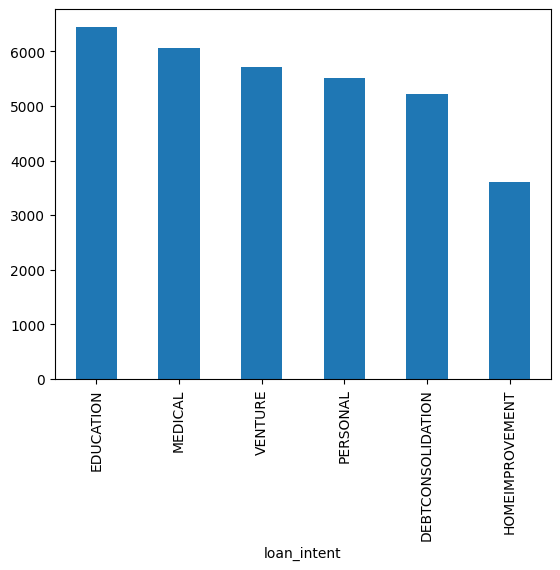

In [6]:
df['loan_intent'].value_counts().plot.bar()
print(df['loan_intent'].value_counts())
sum(df['loan_intent'].value_counts())


<small>**Observation**

1) No null values found for intent
2) Count seems to be equally distributed among intent
3) Intent along with other variables like loan amount, personal income and employment period can be used<br>for risk calculation</small>



##### Loan Grade ❌
<small>**Real Word Meaning:**<br> Internally assigned risk based on user variables<br><br>
**Why excluded:**
1) Loan grade is downstream from the PD modelling, including it may result in potnetial target leakage 


##### Loan Amount ✅
<small>**Real Word Meaning:**<br> Amount user is requesting as a loan<br><br>
**Expected/Impossible values:**
1) Impossible: null values or negative values

**Risk intuition**<br>
1) Individuals with higher loan amounts indicate challenges to repay
2) Loan amount along with person income(ratio) indicates feasibility to repay


**Notes / flags**
1) Check for null values or negative values</small>

count    32581.000000
mean      9589.371106
std       6322.086646
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12200.000000
max      35000.000000
Name: loan_amnt, dtype: float64

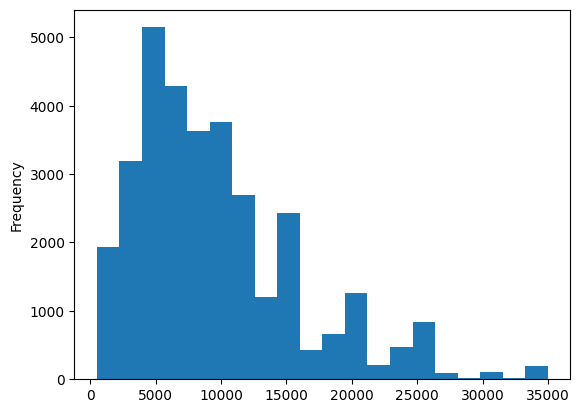

In [7]:
df['loan_amnt'].plot.hist(bins=20)
df['loan_amnt'].describe()

<small>**Observation**

1) Loan amounts are right-skewed and within plausible bounds
2) No sanity violations observed
3) Loan amount requires evaluation against income and tenure for risk</small>



##### Loan Interest Rate ❌

<small>**Real World Meaning:**<br>
Interest rate assigned by the lender based on underwriting and pricing policies.

**Why Excluded:** 
1) Interest rate is a downstream pricing decision derived from risk.
2) Including it would introduce target leakage.</small>


##### Loan Status 🎯
<small>**Real Word Meaning:**<br> Value 1 is user has defaulted and 0 if not defaulted for given dataset <br><br>
**Expected/Impossible values:**
1) Impossible: null or any other value from 0 and 1

**Role in modelling**
1) Used as truth value for defaulting for pd prediction model
2) Use in training the data as well as validating data</small>

In [8]:
df['loan_status'].value_counts(dropna=False)

loan_status
0    25473
1     7108
Name: count, dtype: int64

<small>**Observation**

1) no null values or non binary values found
2) nearly 25% of users defaulted
3) data distribution for verification and training should be divided to preserve 0/1 ratio</small>



##### Loan to income ratio 🔁
<small>**Real Word Meaning:**<br> ratio between loan amount and person income  <br><br>

**Expected/Impossible values:**<br>
1) Impossible: ratio being 0 and null values


**Risk intuition**<br>
1) Higher the ratio more the risk(lower person income)

**Notes / flags**
1) Check for null values or unreasonably extremely large values</small>

9
count    32581.000000
mean         0.170203
std          0.106782
min          0.000000
25%          0.090000
50%          0.150000
75%          0.230000
max          0.830000
Name: loan_percent_income, dtype: float64


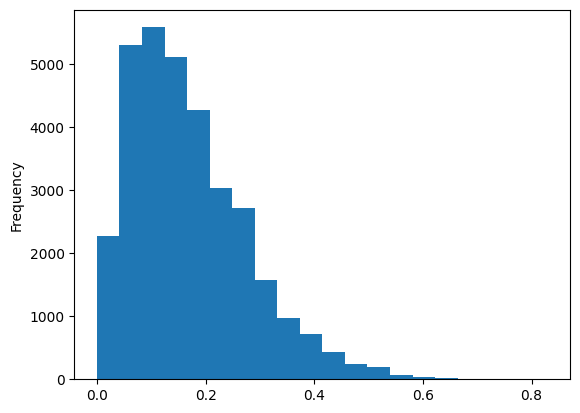

In [9]:
df['loan_percent_income'].plot.hist(bins = 20)
print((df['loan_percent_income'].value_counts()[0]))
print(df['loan_percent_income'].describe())

<small>**Observation**

1) ratio contains 9 '0' values indicating data couldve been rounded off/incorrectly computed considering min amounts for person income
2) most ratios are in the 0.1-0.15 range
3) As a derived quantity this value will be recomputed before processing</small>



##### History defaults ✅
<small>**Real Word Meaning:**<br> History of user defaulting  <br><br>

**Expected/Impossible values:**<br>
1) Impossible: not null values 


**Risk intuition**<br>
1) Past defaults indicates higher risk

**Notes / flags**
1) Check for null values</small>

In [10]:
print(df['cb_person_default_on_file'].value_counts())
df['cb_person_default_on_file'].describe()

cb_person_default_on_file
N    26836
Y     5745
Name: count, dtype: int64


count     32581
unique        2
top           N
freq      26836
Name: cb_person_default_on_file, dtype: object

<small>**Observation**

1) null values not found within data
2) most users have no prior history for defaults
3)  prior default is a strong baseline risk indicator </small>



##### Credit History ✅
<small>**Real Word Meaning:**<br> How long a user has been observed in years  <br><br>

**Expected/Impossible values:**<br>
1) Impossible: not null values or history> age-18


**Risk intuition**<br>
1) Acts as a proxy for information, higher values indicate less risk and vice versa

**Notes / flags**
1) Check for null values and missing values</small>

count    32581.000000
mean         5.804211
std          4.055001
min          2.000000
25%          3.000000
50%          4.000000
75%          8.000000
max         30.000000
Name: cb_person_cred_hist_length, dtype: float64

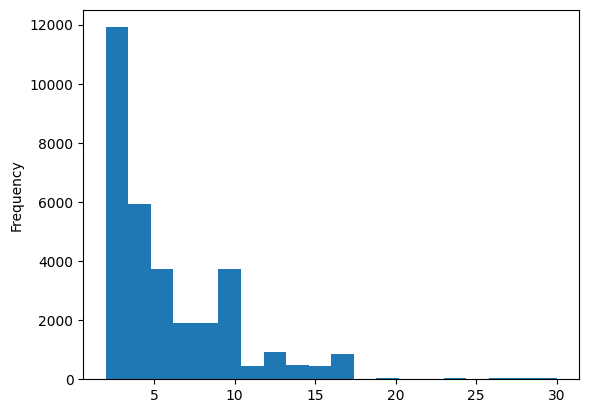

In [11]:
df['cb_person_cred_hist_length'].plot.hist(bins = 20)
df['cb_person_cred_hist_length'].describe()

<small>**Observation**

1) null values not found within data
2) most users have a history of 2-4 years </small>



##### Phase-1 Feature Summary<small>

| Feature | Role | Phase-1 Decision | Why |
|------|------|-----------------|------|
| person_age | ⚠️ | Keep (clean) | Impossible values (>100) observed; requires capping or removal |
| person_income | ✅ | Keep | Right-skewed; meaningful only relative to loan amount |
| person_home_ownership | ✅ | Keep | Contextual categorical feature; useful for segmentation |
| person_emp_length | ⚠️ | Keep (clean) | ~25% violate age constraint; possible unit ambiguity |
| loan_intent | ✅ | Keep | Contextual feature; interacts with income and tenure |
| loan_amnt | ✅ | Keep | Stress multiplier; must be evaluated relative to income |
| loan_grade | ❌ | Exclude | Derived from borrower risk → target leakage |
| loan_int_rate | ❌ | Exclude | Downstream pricing decision → target leakage |
| loan_percent_income | 🔁 | Recompute | Precomputed derived feature; rounding artifacts observed |
| cb_person_default_on_file | ✅ | Keep | Strong baseline risk indicator (historical default) |
| cb_person_cred_hist_length | ✅ | Keep | Proxy for information depth and behavioral stability |
| loan_status | 🎯 | Target | Binary default label (~25% positive class) | </small>
